In [12]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
 

# Convolutional Neural networks 101

see https://github.com/vdumoulin/conv_arithmetic for visualization of different convolution operations and http://cs231n.github.io/convolutional-networks/ for a good tutorial on convolutions.

In [131]:
#LOAD the mnist data. To speed up training we'll only work on a subset of the data.
#Note that we reshape the data from (nsamples, num_features)= (nsamples, nchannels*rows*cols)  -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('mnist.npz')
num_classes = 10
nchannels,rows,cols = 1,28,28
x_train = data['X_train'][:10000].astype('float32')
x_train = x_train.reshape((-1,nchannels,rows,cols))
targets_train = data['y_train'][:10000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1,nchannels,rows,cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1,nchannels,rows,cols))
targets_test = data['y_test'][:500].astype('int32')

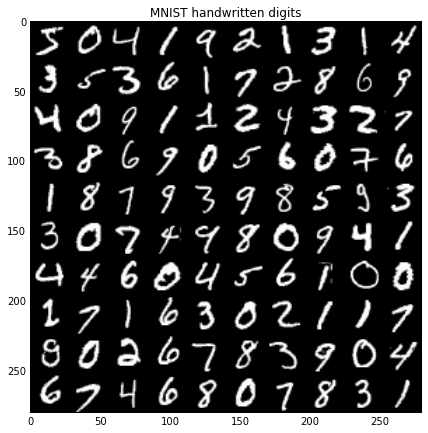

In [132]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [150]:
from lasagne.nonlinearities import leaky_rectify, softmax, tanh, elu
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, batch_norm, DropoutLayer, MaxPool2DLayer

#defined the model
num_class = 10
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,nchannels,rows,cols))
l_conv = Conv2DLayer(l_in,num_filters=36,filter_size=9,stride=1)
l_hid = DenseLayer(l_conv, num_units=100, nonlinearity=elu)
l_out = DenseLayer(l_hid, num_units=num_class, nonlinearity=softmax)

In [151]:
sym_x = T.tensor4('sym_x') # a symbolic variable, this is now a 4-D tensor.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Get network output
train_out = lasagne.layers.get_output(l_out, sym_x, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, sym_x, deterministic=True)


# Get list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()
# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)


# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)


f_eval = theano.function([sym_x],
                     eval_out, on_unused_input='warn')

f_train = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

In [152]:
#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

model = lasagne.layers.get_output(l_out, sym_x)
out = model.eval({sym_x:x}) #this could also include mask etc if used
print("l_out", out.shape)

('l_out', (45, 10))


Epoch 1 : Train Loss 3.786891e-01 , Train acc 0.950700,  Valid acc 0.922000 
Epoch 2 : Train Loss 1.143671e-01 , Train acc 0.982200,  Valid acc 0.950000 
Epoch 3 : Train Loss 6.151814e-02 , Train acc 0.990100,  Valid acc 0.956000 
Epoch 4 : Train Loss 4.058580e-02 , Train acc 0.993000,  Valid acc 0.960000 
Epoch 5 : Train Loss 2.848498e-02 , Train acc 0.994700,  Valid acc 0.948000 
Epoch 6 : Train Loss 1.988037e-02 , Train acc 0.994800,  Valid acc 0.950000 
Epoch 7 : Train Loss 1.286373e-02 , Train acc 0.997800,  Valid acc 0.956000 
Epoch 8 : Train Loss 6.253608e-03 , Train acc 0.998800,  Valid acc 0.960000 
Epoch 9 : Train Loss 4.021367e-03 , Train acc 0.999500,  Valid acc 0.956000 
Epoch 10 : Train Loss 1.763641e-03 , Train acc 1.000000,  Valid acc 0.958000 

Test set Acc:  0.986000


(<matplotlib.text.Text at 0x12689db50>,
 (0.75, 1.03))

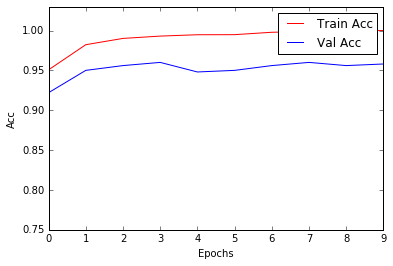

In [153]:
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
for epoch in range(num_epochs):
    #Forward->Backprob->Update params
    cur_loss = 0
    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        target_batch = targets_train[idx]    
        batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
        cur_loss += batch_loss[0]
    loss += [cur_loss/batch_size]
    
    confusion_valid = ConfusionMatrix(num_classes)
    confusion_train = ConfusionMatrix(num_classes)

    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        targets_batch = targets_train[idx]
        net_out = f_eval(x_batch)   
        preds = np.argmax(net_out, axis=-1) 
        confusion_train.batch_add(targets_batch, preds)

    confusion_valid = ConfusionMatrix(num_classes)
    for i in range(num_batches_valid):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_valid[idx]
        targets_batch = targets_valid[idx]
        net_out = f_eval(x_batch)   
        preds = np.argmax(net_out, axis=-1) 
        
        confusion_valid.batch_add(targets_batch, preds)
    
    train_acc_cur = confusion_train.accuracy()
    valid_acc_cur = confusion_valid.accuracy()

    train_acc += [train_acc_cur]
    valid_acc += [valid_acc_cur]
    print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
    % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
net_out = f_eval(x_test)    
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments 1

 1) Noet the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 
 
 2) Can the performance be increases even furhter by stacking more convolution layers ?
 
 3) Maxpooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effetively this gives a small translational invariance and reduces the computation by a factor of four. In the classification algorithm which is useually desireable. Try to either: 
 
     a) add a maxpool layer(add arguement pool_size=2)  after the convolution layer or
     b) set add stride=2 to the arguments of the convolution layer. 
  Verify that this decreases spatial dimension of the image. (print l_conv.output_shape or print   l_maxpool.output_shape). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?
  


# Visualization of filters
Convolution filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc. Below we provide code for visualization of the filters. The best results are obtained with fairly large filters of size 9 and either 16 or 36 filters. 

(36, 1, 9, 9) i.e. the shape is num_filters, num_channels, filter_size, filter_size
learned filter values


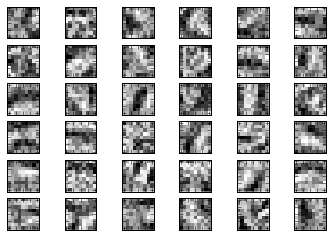

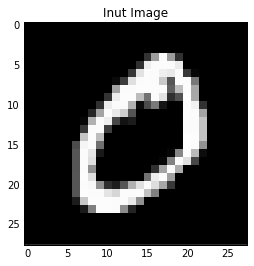

Response from input image convolved with the filters


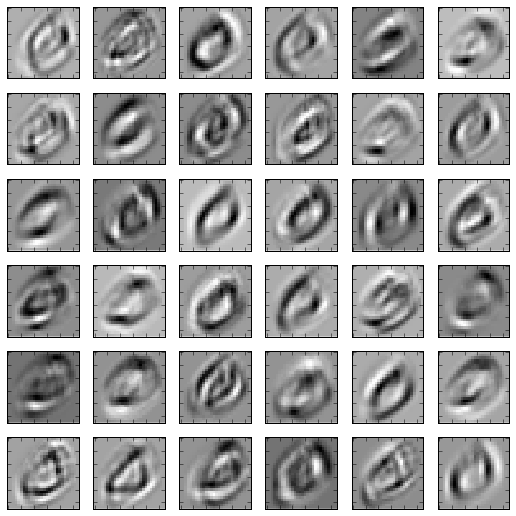

In [173]:
np_W = l_conv.W.get_value() #get the filter values from the conv layer
print np_W.shape, "i.e. the shape is num_filters, num_channels, filter_size, filter_size"
num_filters,num_channels,filter_size,_= np_W.shape
n = int(num_filters**0.5)

np_W_res = np_W.reshape(n,n,num_channels,filter_size,filter_size)
fig, ax = plt.subplots(n,n)
print "learned filter values"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(np_W_res[i,j,0], cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())


idx = 1
plt.figure()
plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
plt.title('Inut Image')
plt.show()

#visalize the filters convolved with an input image
from scipy.signal import convolve2d
np_W_res = np_W.reshape(n,n,num_channels,filter_size,filter_size)
fig, ax = plt.subplots(n,n,figsize=(9,9))
print "Response from input image convolved with the filters"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[i,j,0],mode='same'), cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())



# Assignments 2

The visualized filters will likely look most like noise due to the small amount of training data.

 1) Try to use 10000 traning examples instead and visuzalise the filters again
 
 2) Dropout is a very usefull technique for preventing overfitting. Try to add a DropoutLayer after the convolution layer and hidden layer. This should increase both performance and the "visual appeal" of the filters
 
 3) Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 